## Import Libraries

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow_addons
! pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from scikitplot.metrics import plot_roc

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Hyper Parameters

In [ ]:
class CFG:
    POSITIONAL_EMBEDDING = True
    TOKENIZER_CONV_LAYERS = 8
    PROJECTION_DIM = 128
    NUM_HEADS = 2

    TRANSFORMER_UNITS = [
        PROJECTION_DIM,
        PROJECTION_DIM,
    ]

    TRANSFORMER_LAYERS = 2
    STOCHASTIC_DEPTH_RATE = 0.1
    NUM_CLASSES = 4

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001
    EPOCHS = 500
    BATCH_SIZE = 16
    SEED = 42
    TF_SEED = 768

    #######################################################
    # Note: If you wish to increase the image size beyond #
    #       the current value, make sure you have access  #
    #       to enough memory.                             #
    #######################################################
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = 224
    IMAGE_SHAPE = (224, 224, 3)

## Load Dataset

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/'

In [ ]:
# Generate a summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 4 directories and 0 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/
There are 0 directories and 804 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Pro
There are 0 directories and 985 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Early
There are 0 directories and 963 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Pre
There are 0 directories and 504 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Benign



In [ ]:
df = pd.DataFrame()

In [ ]:
image_path = []
for _dir in os.listdir(DATASET_PATH):
  _path = os.path.join(DATASET_PATH, _dir)
  for _img in os.listdir(_path):
    image_path.append(os.path.join(_path, _img))
image_path = sorted(image_path)

In [ ]:
len(image_path)

3256

In [ ]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Generate label encodings
    # df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)

    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [ ]:
label = image_path[0].split('/')[-2:][0]
label

'Benign'

In [ ]:
images = build_df(image_path, generate_labels(image_path))

In [ ]:
images.head()

image_path   label
0  /content/drive/MyDrive/Research Paper/Health S...     Pre
1  /content/drive/MyDrive/Research Paper/Health S...  Benign
2  /content/drive/MyDrive/Research Paper/Health S...     Pre
3  /content/drive/MyDrive/Research Paper/Health S...     Pre
4  /content/drive/MyDrive/Research Paper/Health S...   Early

### Dataset Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(images['label'])
images['label_encoding'] = le.transform(images['label'])

In [ ]:
sorted(images['label'].unique())

['Benign', 'Early', 'Pre', 'Pro']

In [ ]:
images.head()

image_path   label  label_encoding
0  /content/drive/MyDrive/Research Paper/Health S...     Pre               2
1  /content/drive/MyDrive/Research Paper/Health S...  Benign               0
2  /content/drive/MyDrive/Research Paper/Health S...     Pre               2
3  /content/drive/MyDrive/Research Paper/Health S...     Pre               2
4  /content/drive/MyDrive/Research Paper/Health S...   Early               1

### View Samples

In [ ]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS5)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

def view_sample(image, label, color_map='rgb', fig_size=(6, 6)):
    plt.figure(figsize=fig_size)

    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

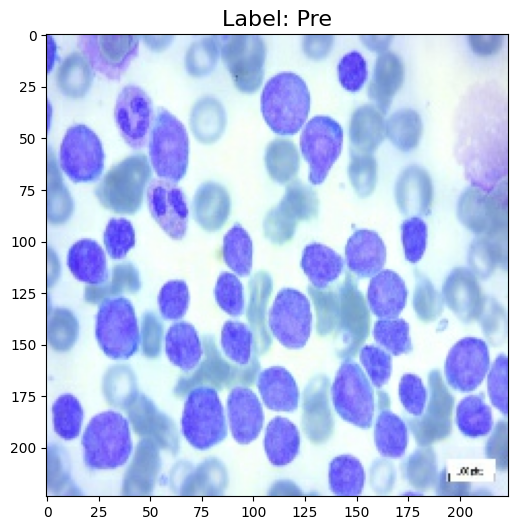

In [ ]:
# Select random sample from train_df
idx = random.sample(images.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(images.image_path[idx]), images.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='rgb')

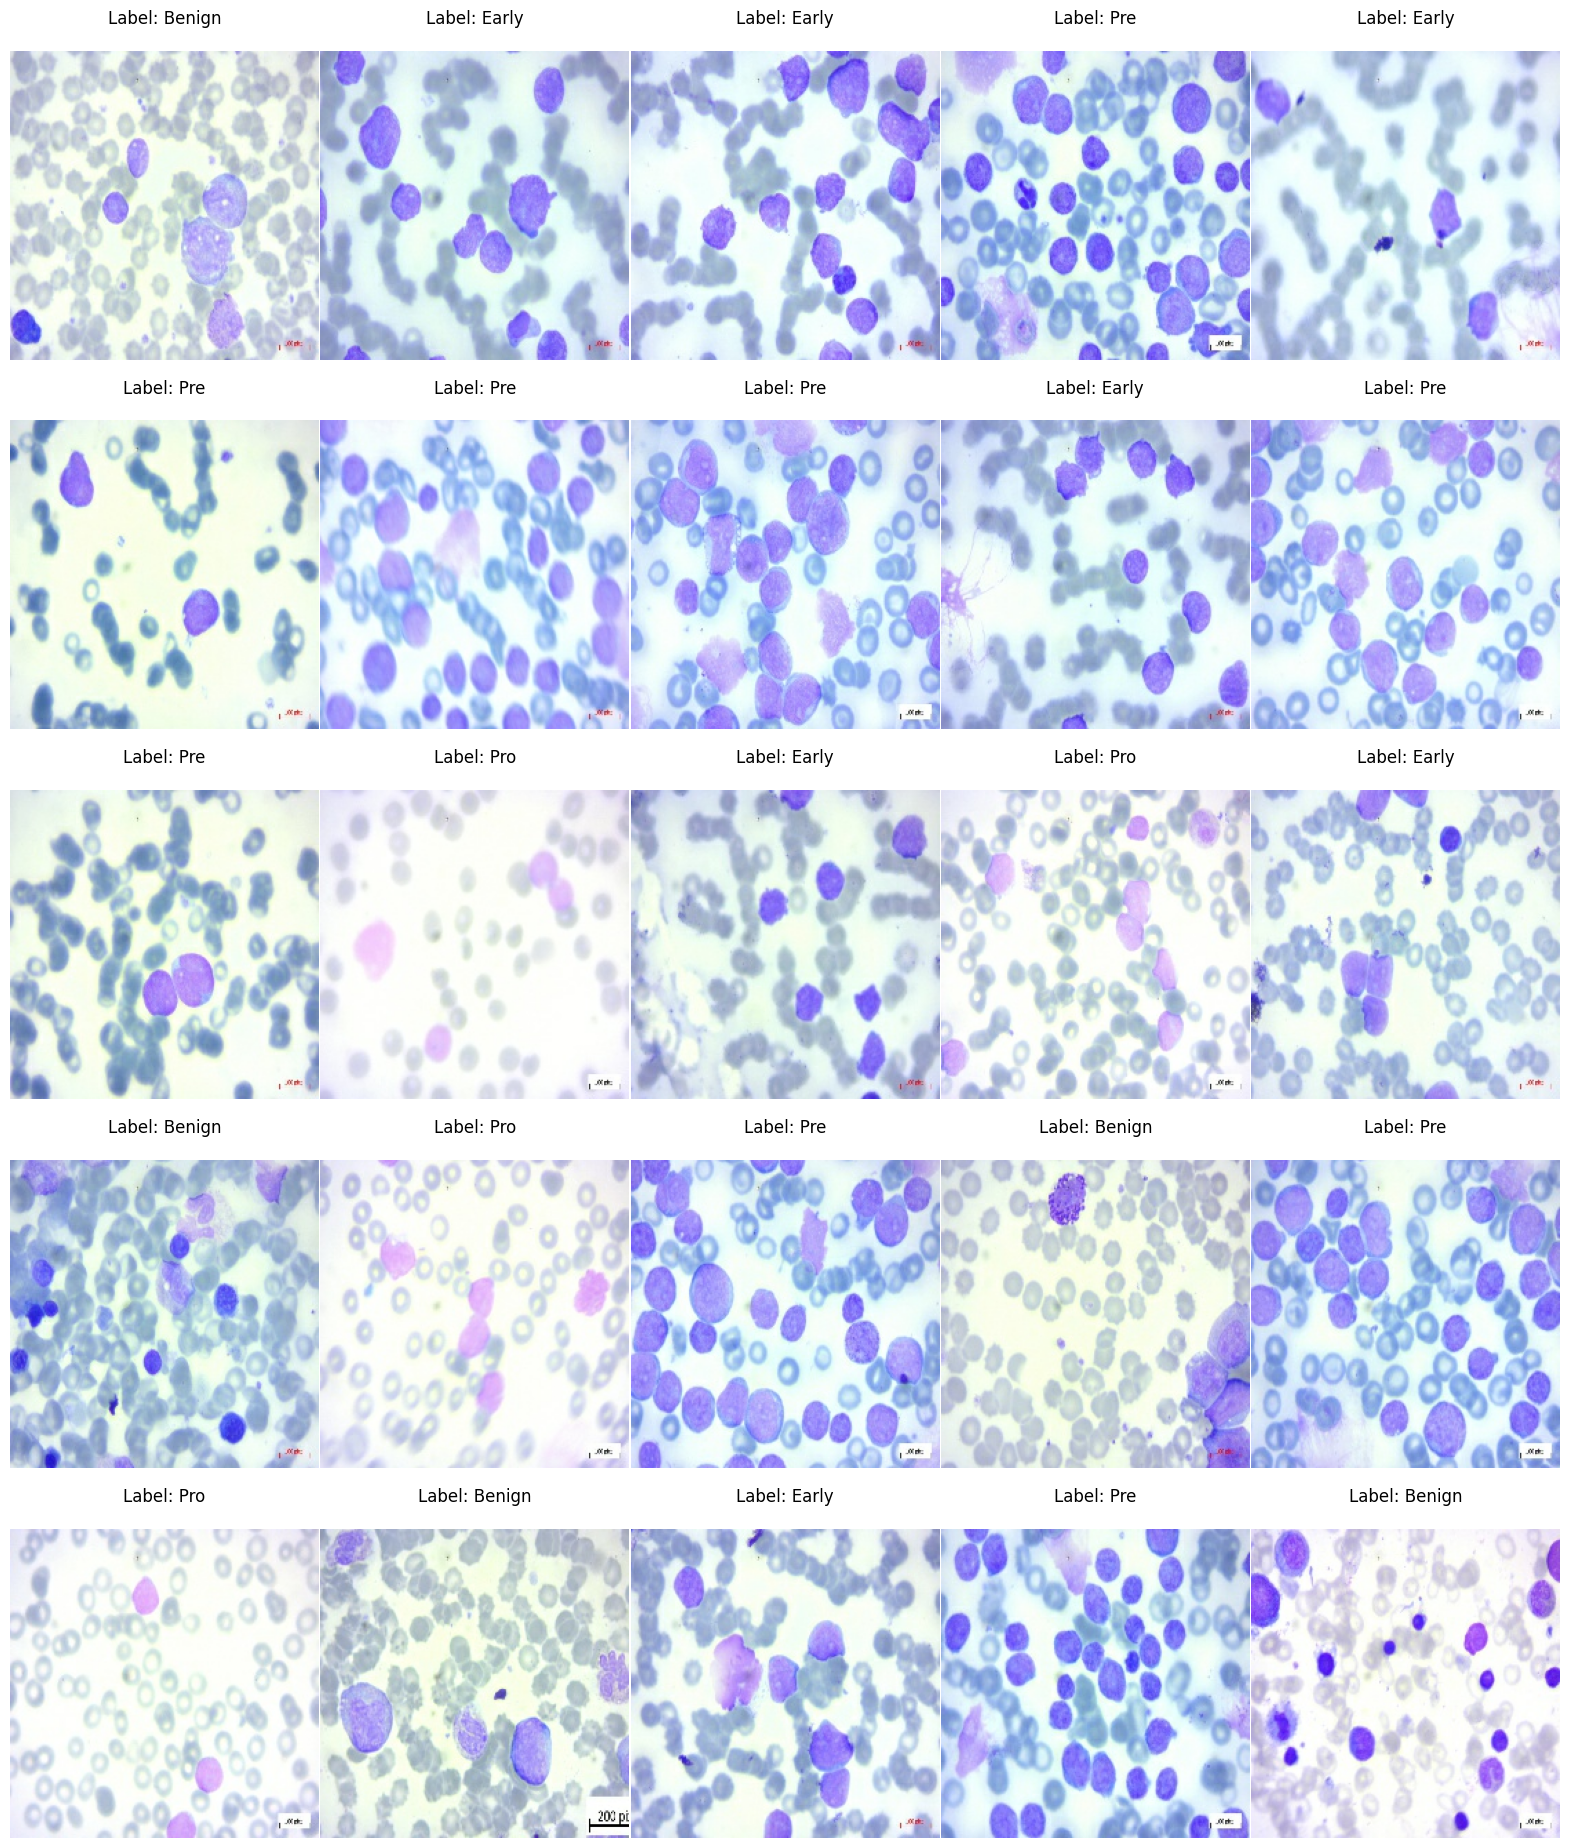

In [ ]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}', pad=20)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.005, hspace=0)

        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)

    plt.show()

    return

view_mulitiple_samples(images, _load,
                       count=25, color_map='rgb',
                       fig_size=(20, 24))

### Split Train Test

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(images['image_path'], images['label_encoding'], test_size=0.2, random_state= CFG.TF_SEED)

In [ ]:
len(train_x), len(train_y),len(valid_x), len(valid_y)

(2604, 2604, 652, 652)

In [ ]:
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=CFG.TF_SEED)

In [ ]:
len(valid_x), len(valid_y),len(test_x), len(test_y)

(326, 326, 326, 326)

### Each Class Distribution Graph

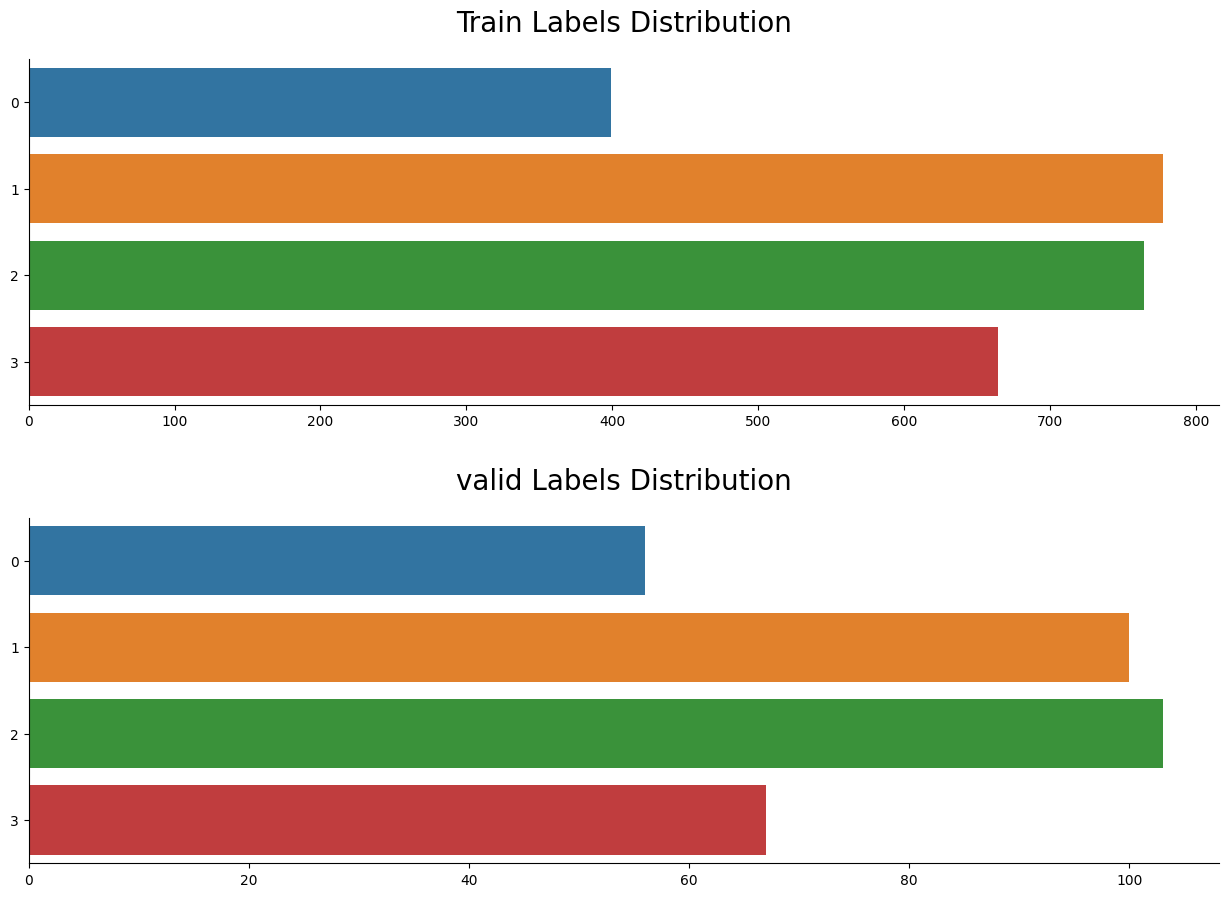

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20, pad=20)
train_distribution = train_y.value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('valid Labels Distribution', fontsize=20, pad=20)
test_distribution = valid_y.value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

sns.despine();

## Augmented Images

In [ ]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
    layers.RandomContrast(0.4, seed=CFG.TF_SEED),

], name='augmentation_layer')

(-0.5, 223.5, 223.5, -0.5)

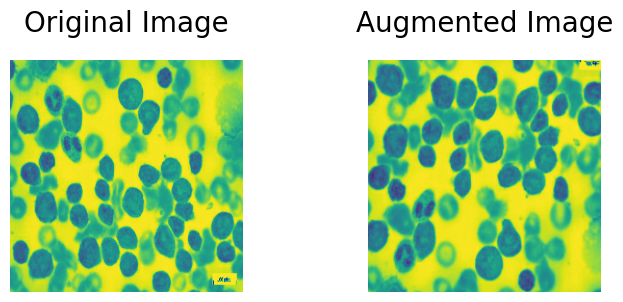

In [ ]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20, pad=20)
ax1.imshow(image, cmap='viridis');
ax1.axis('off')

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20, pad=20)
ax2.imshow(augmentation_layer(image), cmap='viridis');
ax2.axis('off')

## Input Pipeline

In [ ]:
def encode_labels(labels, encode_depth=CFG.NUM_CLASSES):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(X, y,  load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - X: X contain images path
        - y: y contain the label of corosponding X
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = X
    image_labels = encode_labels(y)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_x, train_y, _load, augment=True,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(valid_x, valid_y, _load,
                         batch_size=CFG.BATCH_SIZE,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_x, test_y, _load,
                          batch_size=CFG.BATCH_SIZE,
                          shuffle=False, prefetch=False)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')


Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


### CCT Model

In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=2,
        num_output_channels=[64, 128],
        positional_embedding=True,
        **kwargs,
    ):
        # Initialize tokenizer
        super(CCTTokenizer, self).__init__(**kwargs)
        self.tokenizer = Sequential()

        for _ in range(num_conv_layers):
            # Add Conv Layer
            self.tokenizer.add(
                layers.Conv2D(
                    num_output_channels[_],
                    kernel_size, stride,
                    padding="valid", use_bias=False,
                    activation="relu",kernel_initializer="he_normal",
                    name=f'tokenizer_conv_{_}'
                )
            )
            # Add Padding Layer
            self.tokenizer.add(
                layers.ZeroPadding2D(padding, name=f'tokenizer_padding_{_}')
            )

            # Add MaxPool layer
            self.tokenizer.add(
                layers.MaxPool2D(
                    pooling_kernel_size,
                    pooling_stride, "same",
                    name=f'tokenizer_maxpool_2d_{_}'
                )
            )

        self.positional_embedding = positional_embedding

    def __call__(self, images):
        # Tokenize image
        tokenized_image = self.tokenizer(images)

        # Flatten spatial dimensions to form sequences
        img_seq = tf.reshape(
            tokenized_image,
            (-1, tf.shape(tokenized_image)[1] * tf.shape(tokenized_image)[2], tf.shape(tokenized_image)[-1]),
        )

        return img_seq

    def gen_positional_embedding(self, image_size):
        # Optional: Positional embedding
        if self.positional_embedding:
            # Compute number of sequences to initialise an embedding layer
            # used to compute the positional embeddings.
            dummy_inputs = tf.ones((1, image_size, image_size, 3)) # dummy input

            # Pass input to tokenizer
            dummy_outputs = self.__call__(dummy_inputs)

            # Get seq length and projection dimension from dummy output
            sequence_length = dummy_outputs.shape[1]
            projection_dim = dummy_outputs.shape[-1]

            # Generate an embedding layer
            embedding_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim, name='tokenizer_pos_embedding'
            )

            return embedding_layer, sequence_length
        else:
            return None # Positional Embedding Disabled

### StochasticDepth Layer

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, droupout_rate, **kwargs):
        super().__init__(**kwargs)
        self.droupout_rate = droupout_rate

    def __call__(self, x, training=None):
        if training:
            # Set survival rate
            survival_rate = 1 - self.droupout_rate

            # Define output shape
            shape = (x.shape[0],) + (1,) * (x.shape[0] - 1)

            # Generate random dropouts
            random_tensor = survival_rate + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)

            return (x / survival_rate) * random_tensor

        # Return input if not training
        return x

### Multi-Layer-Perception

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Build Model

In [ ]:
def create_cct_model(
    image_size=CFG.IMAGE_SIZE,
    input_shape=CFG.IMAGE_SHAPE,
    num_heads=CFG.NUM_HEADS,
    projection_dim=CFG.PROJECTION_DIM,
    transformer_units=CFG.TRANSFORMER_UNITS,
    transformer_layers=CFG.TRANSFORMER_LAYERS,
    possitional_embedding=CFG.POSITIONAL_EMBEDDING,
    stochastic_depth_rate = CFG.STOCHASTIC_DEPTH_RATE
):
    # Define Input Layer
    inputs = layers.Input(input_shape, dtype=tf.float32, name='input_image')

    # Augment input image
    augmented = augmentation_layer(inputs)

    # Tokenize image patches
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding to tokens
    if possitional_embedding:
        pos_embedding_layer, seq_length = cct_tokenizer.gen_positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)

        pos_embeddings = pos_embedding_layer(positions)
        encoded_patches += pos_embeddings

    # Compute Stochastic Depth probabilities
    dpr = [_ for _ in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Generate layers for the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization
        norm_layer_1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Generate Multi-Head Self-Attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(norm_layer_1, norm_layer_1)

        # Skip connection 1
        attention_output = StochasticDepth(dpr[_])(attention_output)
        residual_1 = layers.Add()([
            attention_output, encoded_patches
        ])

        # Layer normalization
        norm_layer_2 = layers.LayerNormalization(epsilon=1e-5)(residual_1)

        # MLP Layer
        mlp_layer = mlp(
            norm_layer_2, hidden_units=transformer_units, dropout_rate=0.1
        )

        # Skip connection 2
        stochastic_depth_1 = StochasticDepth(dpr[_])(mlp_layer)
        encoded_patches = layers.Add()([stochastic_depth_1, residual_1])

    # Apply sequence pooling
    seq_representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

    attention_weights = tf.nn.softmax(layers.Dense(1)(seq_representation), axis=1)

    weighted_seq_representation = tf.matmul(
        attention_weights,
        seq_representation,
        transpose_a=True
    )
    weighted_seq_representation = tf.squeeze(weighted_seq_representation, -2)

    # Feed forward to output layer
    output_layer = layers.Dense(
        CFG.NUM_CLASSES,
        activation=tf.nn.softmax,
        name='output_layer'
    )(weighted_seq_representation)

    # Generate Model
    model = tf.keras.Model(
        inputs=[inputs], outputs=[output_layer],
        name='compact_convolutional_transformer_model'
    )

    return model

In [ ]:
# Construct Model
cct_model = create_cct_model()

# View model summary
cct_model.summary()

Model: "compact_convolutional_transformer_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augmentation_layer (Sequential  (224, 224, None)    0           ['input_image[0][0]']            
 )                                                                                                
                                                                                                  
 sequential (Sequential)        (None, 56, 56, 128)  75456       ['augmentation_layer[0][0]']     
                                                            

In [ ]:
# Explore model visually
plot_model(
    cct_model, dpi=100,
    show_shapes=True
)

### CallBack Phases

In [ ]:
paths = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Model'
model_path = os.path.join(paths+"/files/", "model.h5")
csv_path = os.path.join(paths+"/files/", "log.csv")
#--------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
#--------------------------------------------------------
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)

# (Optional) Define Reduce Learning Rate Callback
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     patience=6,
#     factor=0.1,
#     verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [
        ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

METRICS = ['accuracy']

### Compiling Phase

In [ ]:
tf.random.set_seed(CFG.SEED)

# Compile the model
cct_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0,axis=-1,reduction="auto",name="categorical_crossentropy",
),
    optimizer=tfa.optimizers.AdamW(learning_rate=CFG.LEARNING_RATE, weight_decay=CFG.WEIGHT_DECAY),
    metrics=METRICS
)

# Train the model
print(f'Training {cct_model.name}.')
print(f'Train on {len(train_x)}, {len(train_y)} samples, validate on {len(valid_x)}, {len(valid_y)} samples.')
print('----------------------------------')



Training compact_convolutional_transformer_model.
Train on 2604, 2604 samples, validate on 326, 326 samples.
----------------------------------


In [ ]:
tf.keras.backend.clear_session()

## Training Phase

In [ ]:
cct_model_history = cct_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=CFG.BATCH_SIZE,
    epochs=CFG.EPOCHS,
    callbacks=CALLBACKS,
)

Epoch 1/500
163/163 [==============================] - ETA: 0s - loss: 1.0951 - accuracy: 0.5326
Epoch 1: val_loss improved from inf to 0.59215, saving model to /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Model/files/model.h5
163/163 [==============================] - 478s 3s/step - loss: 1.0951 - accuracy: 0.5326 - val_loss: 0.5922 - val_accuracy: 0.7086 - lr: 0.0010
Epoch 2/500
163/163 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.7957
Epoch 2: val_loss improved from 0.59215 to 0.42809, saving model to /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Model/files/model.h5
163/163 [==============================] - 139s 851ms/step - loss: 0.5213 - accuracy: 0.7957 - val_loss: 0.4281 - val_accuracy: 0.8282 - lr: 0.0010
Epoch 3/500
163/163 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.8621
Epoch 3: val_loss improved from 0.42809 to 0.35005, saving model t

# Valid Sets

## Prediction Phase

In [ ]:
# Generate model probabilities and associated predictions
cct_test_probabilities = cct_model.predict(val_ds, verbose=1)
cct_test_predictions = tf.argmax(cct_test_probabilities, axis=1)

21/21 [==============================] - 5s 211ms/step


### Plot Evaluation Graphs

In [ ]:
def plot_training_curves(history, ):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

    sns.despine();

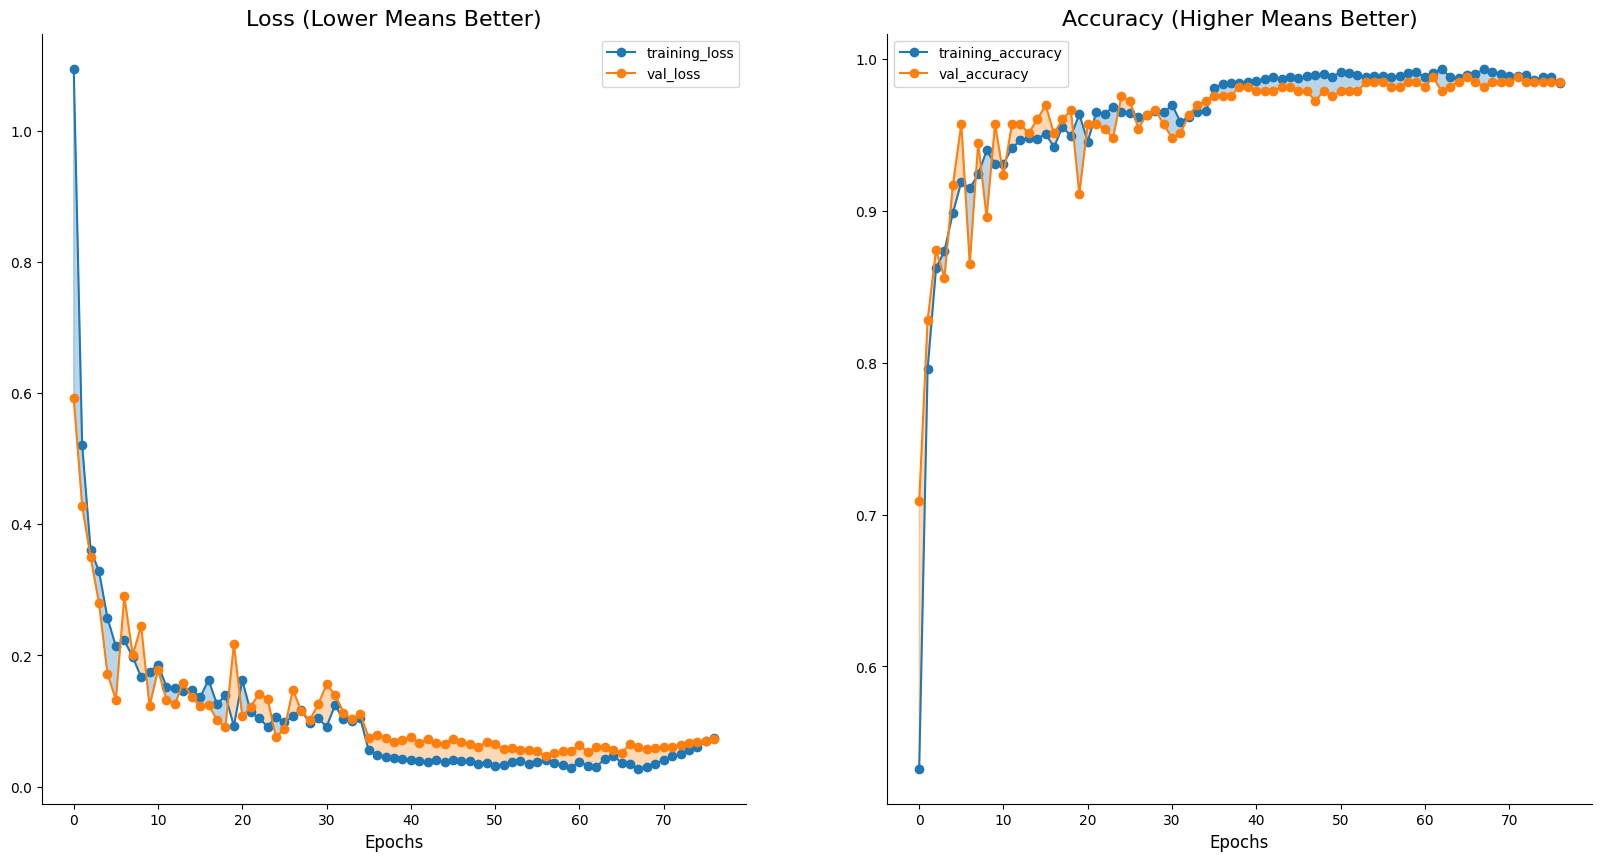

In [ ]:
# plot cct model training history
plot_training_curves(cct_model_history)

### Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

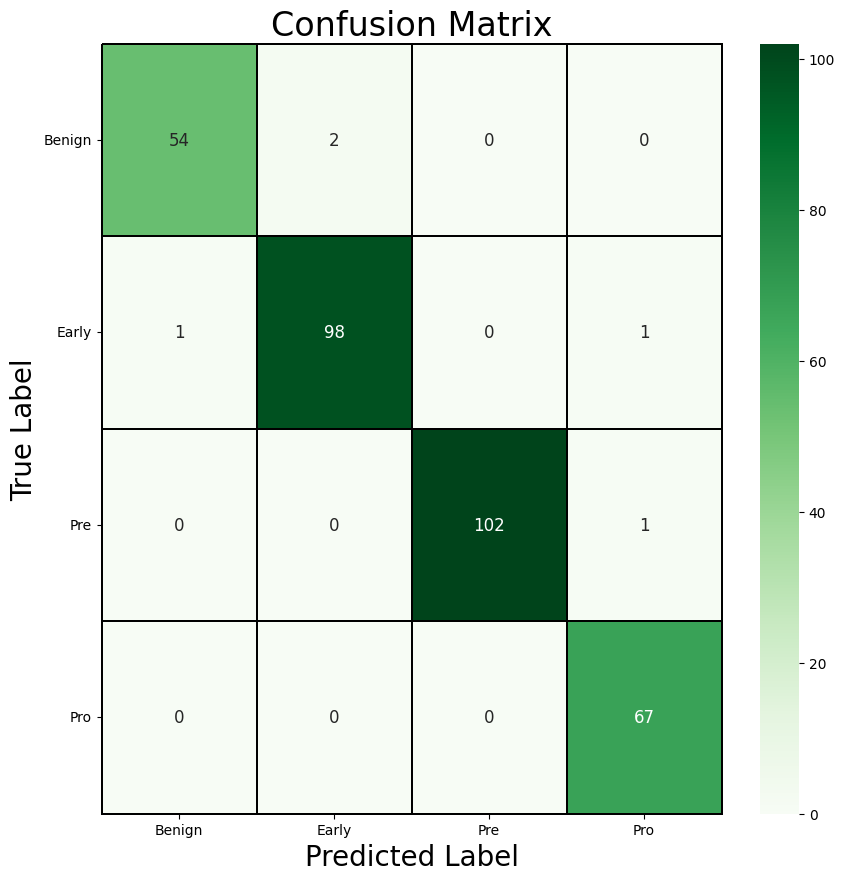

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    valid_y,
    cct_test_predictions,
    figsize=(10, 10),
    classes=class_names)

## Plot ROC

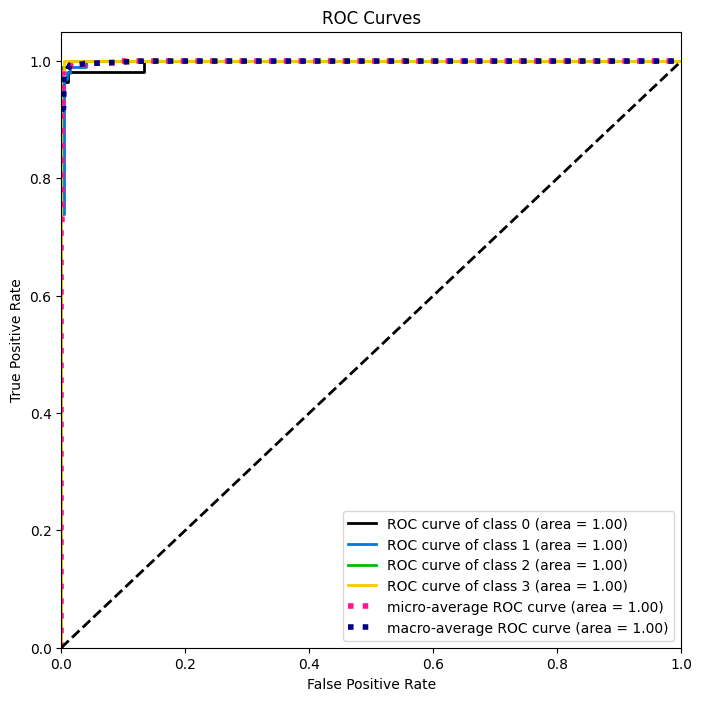

In [ ]:
plot_roc(valid_y,
         cct_test_probabilities,
         figsize=(8, 8), title_fontsize='large');

In [ ]:
print(classification_report(valid_y,
                            cct_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97        56
       Early       0.98      0.98      0.98       100
         Pre       1.00      0.99      1.00       103
         Pro       0.97      1.00      0.99        67

    accuracy                           0.98       326
   macro avg       0.98      0.98      0.98       326
weighted avg       0.98      0.98      0.98       326



## Performance Evaluation

In [ ]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Record CCT model performance scores
cct_performance = generate_preformance_scores(valid_y,
                                              cct_test_predictions,
                                              cct_test_probabilities)


Performance Metrics:

accuracy_score:		0.9847

_____________________________________________
precision_score:	0.9848

_____________________________________________
recall_score:		0.9847

_____________________________________________
f1_score:		0.9847

_____________________________________________
matthews_corrcoef:	0.9792



# Test Sets

In [ ]:
# Generate model probabilities and associated predictions
cct_test_probabilities = cct_model.predict(test_ds, verbose=1)
cct_test_predictions = tf.argmax(cct_test_probabilities, axis=1)

21/21 [==============================] - 43s 2s/step


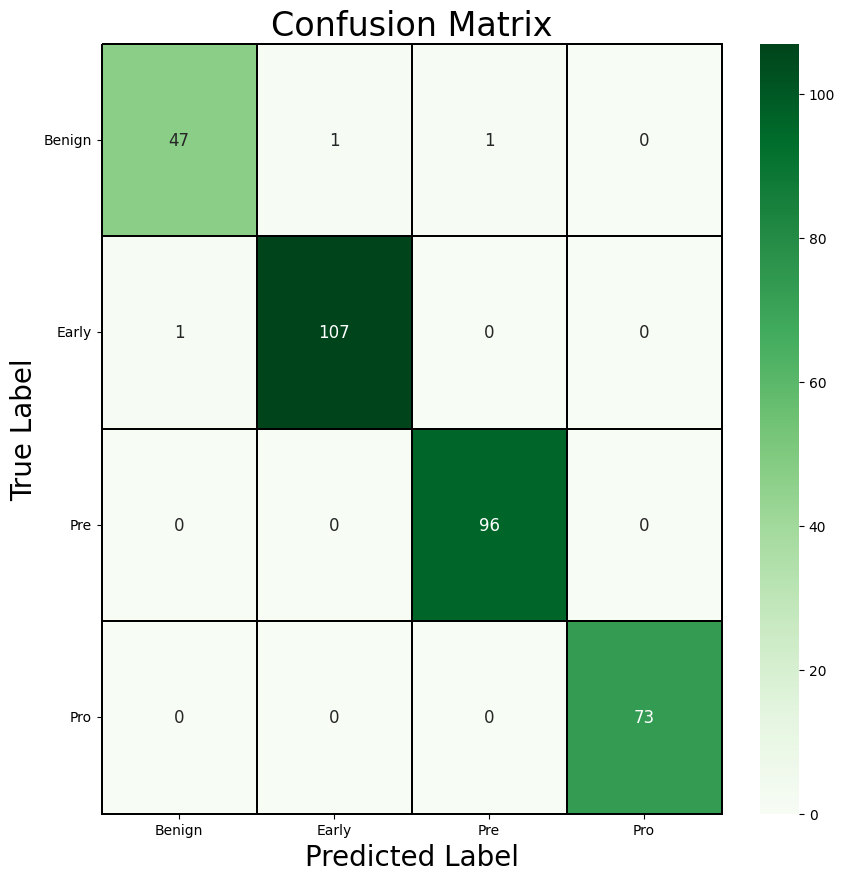

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    test_y,
    cct_test_predictions,
    figsize=(10, 10),
    classes=class_names)

In [ ]:
print(classification_report(test_y,
                            cct_test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97        49
       Early       0.99      0.99      0.99       108
         Pre       0.99      1.00      0.99        96
         Pro       1.00      1.00      1.00        73

    accuracy                           0.99       326
   macro avg       0.99      0.99      0.99       326
weighted avg       0.99      0.99      0.99       326



In [ ]:
# Record CCT model performance scores
cct_performance = generate_preformance_scores(test_y,
                                              cct_test_predictions,
                                              cct_test_probabilities)


Performance Metrics:

accuracy_score:		0.9908

_____________________________________________
precision_score:	0.9908

_____________________________________________
recall_score:		0.9908

_____________________________________________
f1_score:		0.9908

_____________________________________________
matthews_corrcoef:	0.9874

